In [25]:
# Import standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import KEY Machine Learning libraries from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load your cleaned dataset from Day 1
df = pd.read_csv('../Day1_DataWrangling/data/cleaned_googleplaystore.csv')

In [26]:
# Find rows where the 'Price' column contains non-numeric values
problematic_rows = df[df['Price'].str.contains('Everyone', na=False)]
print("Rows where 'Price' contains 'Everyone':")
print(problematic_rows)

# Let's also check what unique values are in the Price column
print("\nUnique values in 'Price' column:")
print(df['Price'].unique()[:20])  # Show first 20 unique values

Rows where 'Price' contains 'Everyone':
         Sr.                                      App Category  Rating  \
10472  10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0   

      Reviews    Size Installs Type     Price Content Rating  \
10472    3.0M  1,000+     Free    0  Everyone        Unknown   

                  Genres Last Updated Current Ver Android Ver  \
10472  February 11, 2018       1.0.19  4.0 and up     Unknown   

       Rating_normalized  
10472                1.0  

Unique values in 'Price' column:
['0' '$4.99' '$3.99' '$6.99' '$1.49' '$2.99' '$7.99' '$5.99' '$3.49'
 '$1.99' '$9.99' '$7.49' '$0.99' '$9.00' '$5.49' '$10.00' '$24.99'
 '$11.99' '$79.99' '$16.99']


In [27]:
# Drop rows where Price contains non-numeric values
# First, identify what constitutes a valid price pattern
valid_price_pattern = r'^\$?\d+(\.\d{1,2})?$|^0$'  # Matches: $4.99, 4.99, 0

# Find rows to keep
mask = df['Price'].str.match(valid_price_pattern, na=False)
print(f"Number of invalid Price rows: {len(df) - mask.sum()}")

# Keep only rows with valid prices
df = df[mask].copy()

Number of invalid Price rows: 1


In [28]:
# --- HANDLING NON-NUMERIC COLUMNS ---
df_ml = df.copy()

# 1. DROP THE COLUMNS THAT ARE NOT USEFUL
df_ml = df_ml.drop(['App', 'Current Ver', 'Android Ver'], axis=1)

# 2. CONVERT 'Reviews' to numeric (handles commas, 'M', 'k')
def convert_reviews(review_str):
    if pd.isna(review_str):
        return np.nan
    review_str = str(review_str).strip().upper()
    review_str = review_str.replace(',', '')
    
    if review_str.endswith('M'):
        multiplier = 1_000_000
        review_str = review_str.rstrip('M')
    elif review_str.endswith('K'):
        multiplier = 1_000
        review_str = review_str.rstrip('K')
    else:
        multiplier = 1
        
    try:
        return float(review_str) * multiplier
    except:
        return np.nan

df_ml['Reviews'] = df_ml['Reviews'].apply(convert_reviews)
df_ml['Reviews'] = df_ml['Reviews'].fillna(df_ml['Reviews'].median())

# 3. CONVERT 'Size' to numeric (handles 'M', 'k', and 'Varies with device')
def convert_size(size_str):
    if size_str == 'Varies with device':
        return np.nan
    size_str = size_str.strip()
    multiplier = 1
    if size_str.endswith('M'):
        multiplier = 1
        size_str = size_str.rstrip('M')
    elif size_str.endswith('k'):
        multiplier = 1/1000
        size_str = size_str.rstrip('k')
    try:
        return float(size_str) * multiplier
    except:
        return np.nan

df_ml['Size'] = df_ml['Size'].apply(convert_size)
df_ml['Size'] = df_ml['Size'].fillna(df_ml['Size'].median())

# 4. CONVERT 'Installs' to numeric (handle 'Free', '+', commas)
def convert_installs(install_str):
    if pd.isna(install_str):
        return np.nan
    install_str = str(install_str).strip()
    
    if install_str == 'Free':
        return 0
    elif install_str in ['Paid', 'Varies with device']:
        return np.nan
        
    install_str = install_str.replace('+', '').replace(',', '')
    try:
        return int(install_str)
    except ValueError:
        return np.nan

df_ml['Installs'] = df_ml['Installs'].apply(convert_installs)
df_ml['Installs'] = df_ml['Installs'].fillna(df_ml['Installs'].median())

# 5. CONVERT 'Price' to numeric (remove '$')
df_ml['Price'] = df_ml['Price'].str.replace('$', '', regex=False).astype(float)

# 6. CONVERT 'Last Updated' to numeric (days since update)
df_ml['Last Updated'] = pd.to_datetime(df_ml['Last Updated'])
reference_date = pd.Timestamp('2024-01-01')
df_ml['Days_Since_Update'] = (reference_date - df_ml['Last Updated']).dt.days
df_ml = df_ml.drop('Last Updated', axis=1)

print("New data types after conversion:")
print(df_ml.dtypes)

New data types after conversion:
Sr.                    int64
Category              object
Rating               float64
Reviews              float64
Size                 float64
Installs               int64
Type                  object
Price                float64
Content Rating        object
Genres                object
Rating_normalized    float64
Days_Since_Update      int64
dtype: object


In [29]:
# Check what unique values are in the Installs column
print("Unique values in 'Installs' column:")
print(df_ml['Installs'].unique())

# Check value counts to see how many 'Free' values there are
print("\nValue counts for 'Installs':")
print(df_ml['Installs'].value_counts())

Unique values in 'Installs' column:
[     10000     500000    5000000   50000000     100000      50000
    1000000   10000000       5000  100000000 1000000000       1000
  500000000         50        100        500         10          1
          5          0]

Value counts for 'Installs':
Installs
1000000       1579
10000000      1252
100000        1169
10000         1054
1000           907
5000000        752
100            719
500000         539
50000          479
5000           477
100000000      409
10             386
500            330
50000000       289
50             205
5               82
500000000       72
1               67
1000000000      58
0               15
Name: count, dtype: int64


In [30]:
# 1. Define your Target and Features using the NEW df_ml DataFrame
y = df_ml['Type']

numerical_features = ['Reviews', 'Size', 'Installs', 'Price', 'Days_Since_Update', 'Rating', 'Rating_normalized']
X = df_ml[numerical_features]

# 2. Encode the Categorical TARGET Variable ('Type')
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Free -> 0, Paid -> 1

# 3. Check for any remaining categorical features in X
# There shouldn't be any if you dropped 'Category', 'Genres' etc. earlier?
# If there are, encode them with get_dummies
categorical_columns = X.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print(f"Encoding remaining categorical features: {categorical_columns}")
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# 4. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

print("Final feature matrix shape:", X.shape)
print("Final feature data types:")
print(X.dtypes)

Final feature matrix shape: (10840, 7)
Final feature data types:
Reviews              float64
Size                 float64
Installs               int64
Price                float64
Days_Since_Update      int64
Rating               float64
Rating_normalized    float64
dtype: object


In [31]:
# This is the most important debugging step
print("Data Types of your Feature Matrix (X):")
print(X.dtypes)

# Let's find any remaining non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object', 'category']).columns
if len(non_numeric_columns) > 0:
    print(f"\n!!! WARNING: Found non-numeric columns: {list(non_numeric_columns)}")
    print("\nSample values from these columns:")
    for col in non_numeric_columns:
        print(f"{col}: {X[col].iloc[0]}")
else:
    print("\nAll columns are numeric. Good to go!")

Data Types of your Feature Matrix (X):
Reviews              float64
Size                 float64
Installs               int64
Price                float64
Days_Since_Update      int64
Rating               float64
Rating_normalized    float64
dtype: object

All columns are numeric. Good to go!


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
# stratify=y ensures the proportion of Free/Paid apps is the same in both train and test sets

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Proportion of 'Paid' apps in training set: {y_train.mean():.2f}")
print(f"Proportion of 'Paid' apps in testing set: {y_test.mean():.2f}")

Training set size: (7588, 7)
Testing set size: (3252, 7)
Proportion of 'Paid' apps in training set: 0.07
Proportion of 'Paid' apps in testing set: 0.08


In [33]:
# 1. Create the model object
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# 2. Train the model on the training data
logreg_model.fit(X_train, y_train)

# 3. Make predictions
logreg_predictions = logreg_model.predict(X_test)

# 4. Evaluate the model's performance
print("=== Logistic Regression ===")
print('Accuracy:', accuracy_score(y_test, logreg_predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, logreg_predictions))
print('\nClassification Report:')
print(classification_report(y_test, logreg_predictions))

=== Logistic Regression ===
Accuracy: 1.0

Confusion Matrix:
[[3005    0]
 [   0  247]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3005
           1       1.00      1.00      1.00       247

    accuracy                           1.00      3252
   macro avg       1.00      1.00      1.00      3252
weighted avg       1.00      1.00      1.00      3252



In [34]:
# 1. Create the model object
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Make predictions
rf_predictions = rf_model.predict(X_test)

# 4. Evaluate
print("\n=== Random Forest Classifier ===")
print('Accuracy:', accuracy_score(y_test, rf_predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, rf_predictions))
print('\nClassification Report:')
print(classification_report(y_test, rf_predictions))


=== Random Forest Classifier ===
Accuracy: 1.0

Confusion Matrix:
[[3005    0]
 [   0  247]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3005
           1       1.00      1.00      1.00       247

    accuracy                           1.00      3252
   macro avg       1.00      1.00      1.00      3252
weighted avg       1.00      1.00      1.00      3252



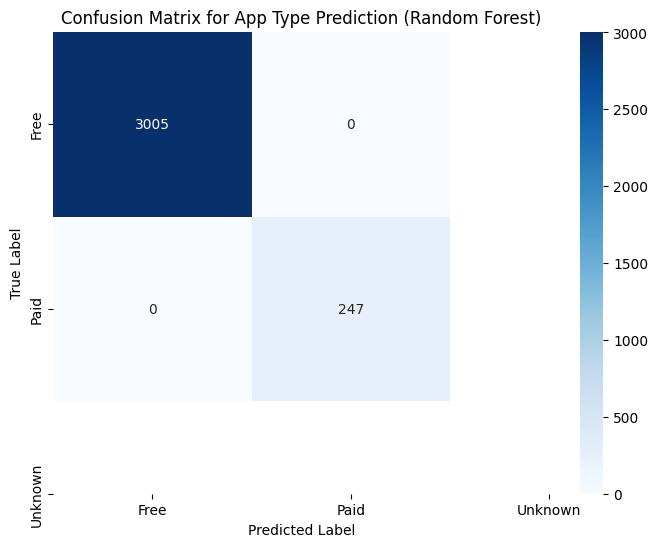

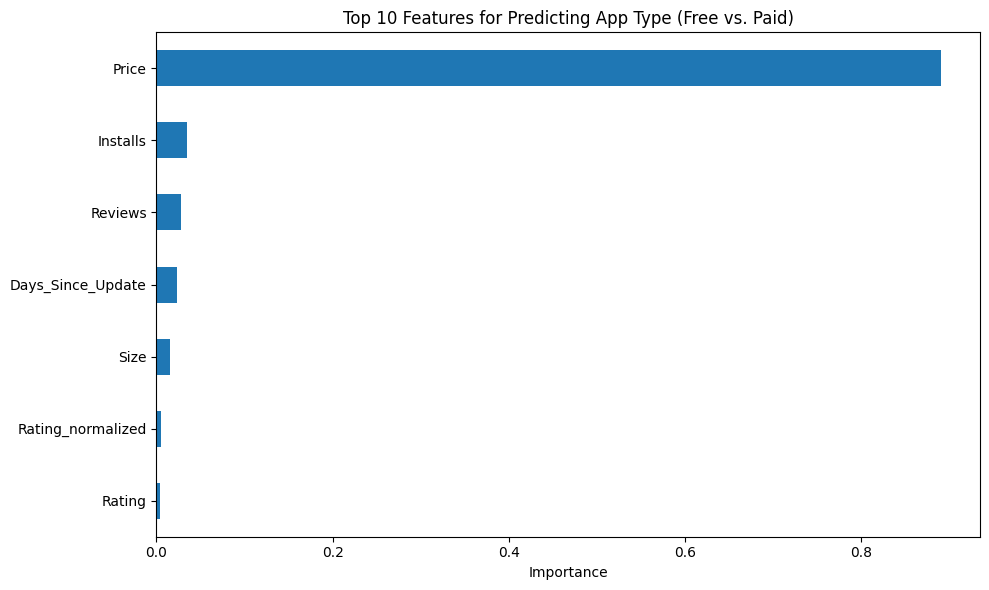

In [35]:
# Plot the Confusion Matrix for the best model (e.g., Random Forest)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, rf_predictions),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for App Type Prediction (Random Forest)')
plt.show()

# Check which features were most important for the prediction
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh') # Horizontal bar chart
plt.title('Top 10 Features for Predicting App Type (Free vs. Paid)')
plt.xlabel('Importance')
plt.gca().invert_yaxis() # To show the most important at the top
plt.tight_layout()
plt.show()

In [36]:
# Import joblib for saving/loading models
import joblib

# Assuming 'rf_model' was your best Random Forest model from Day 4
# Save the model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')

print("Model saved as 'random_forest_model.pkl'")


Model saved as 'random_forest_model.pkl'
